# Yearly Air Quality of India

In this notebook I will perform cleaning, exploratory analysis and prediction on the dataset files. I will focus on per-state analytics and predictions.

<div><img src="IndiaStatesByRTOcodes.png" width="400"/></div>

## Import Libraries

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

## Load State Information

First we define the state and its appropriate code for reference as well as all the available metrics.

In [2]:
df_states = pd.read_csv('dataset/stations_info.csv')
df_states.drop(columns=['agency', 'station_location', 'start_month'], inplace=True)
df_states.head()

,file_name,state,city,start_month_num,start_year
0,AP001,Andhra Pradesh,Tirupati,7,2016
1,AP002,Andhra Pradesh,Vijayawada,5,2017
2,AP003,Andhra Pradesh,Visakhapatnam,7,2017
3,AP004,Andhra Pradesh,Rajamahendravaram,9,2017
4,AP005,Andhra Pradesh,Amaravati,11,2017


In [3]:
unique_states = df_states['state'].unique()
unique_states

array(['Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar',
       'Chhattisgarh', 'Chandigarh', 'Delhi', 'Gujarat',
       'Himachal Pradesh', 'Haryana', 'Jharkhand', 'Jammu and Kashmir',
       'Karnataka', 'Kerala', 'Maharashtra', 'Meghalaya', 'Manipur',
       'Madhya Pradesh', 'Mizoram', 'Nagaland', 'Odisha', 'Punjab',
       'Puducherry', 'Rajasthan', 'Sikkim', 'Telangana', 'Tamil Nadu',
       'Tripura', 'Uttarakhand', 'Uttar Pradesh', 'West Bengal'],
      dtype=object)

We are working with a large dataset which is split in multiple files (for each city in each state), collected through different agencies. It is expected<br>
that each agency collected metrics in various formats. In addition to this, agencies started collecting data at different dates. We should check for all these notes.

First I will create a function that will return a dataframe combining all agency measurements in a given state.

In [4]:
def combine_state_df(state_name):
    '''
    Combine all state files into a single dataframe and attaching the city information.

    Parameters
    ----------
        state_name (str): The name of the state

    Return
    ------
        df (DataFrame): The combined dataframe from all files of a specific state
    '''
    
    state_code = df_states[df_states['state'] == state_name]['file_name'].iloc[0][:2]
    state_files = glob.glob(f'dataset/{state_code}*.csv')
    print(f'Combining a total of {len(state_files)} files...\n')

    combined_df = []
    
    for state_file in state_files:
        file_name = state_file.split('dataset\\')[1][0:-4]
        file_df = pd.read_csv(state_file)
        file_df['city'] = df_states[df_states['file_name'] == file_name]['city'].values[0]
        file_df['city'] = file_df['city'].astype('string')
        combined_df.append(file_df)
        
    return pd.concat(combined_df)

In order to understand the properties of the dataset provided, I will take a closer look on the measurements for India's capital state, Delhi.

In [5]:
df = combine_state_df('Delhi')

Combining a total of 40 files...



In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2796171 entries, 0 to 20841
Data columns (total 60 columns):
 #   Column               Dtype  
---  ------               -----  
 0   From Date            object 
 1   To Date              object 
 2   PM2.5 (ug/m3)        float64
 3   PM10 (ug/m3)         float64
 4   NO (ug/m3)           float64
 5   NO2 (ug/m3)          float64
 6   NOx (ppb)            float64
 7   NH3 (ug/m3)          float64
 8   SO2 (ug/m3)          float64
 9   CO (mg/m3)           float64
 10  Ozone (ug/m3)        float64
 11  Benzene (ug/m3)      float64
 12  city                 string 
 13  Toluene (ug/m3)      float64
 14  Eth-Benzene (ug/m3)  float64
 15  MP-Xylene (ug/m3)    float64
 16  O Xylene (ug/m3)     float64
 17  Temp (degree C)      float64
 18  RH (%)               float64
 19  WS (m/s)             float64
 20  WD (deg)             float64
 21  SR (W/mt2)           float64
 22  BP (mmHg)            float64
 23  VWS (m/s)            float64
 24  

From these dataframe details we can see this state's feature vector comprises 58 different metrics and a total of 2796171 records!

## Data Preprocessing

I noticed that there are two features, `From Date` and `To Date` which are both Pandas objects. These feature vectors describe a one hour<br>
window for all the metric collected at that point. Since we are dealing with time series data, it is also common to use a datetime index. I decided<br>
to keep the `From Date` as index and transform it from a Pandas object into the datetime format.

In [7]:
# Make the 'From Date' column the index as datetime
def create_dt_index(dataframe):
    dataframe = dataframe.drop(columns='To Date')
    dataframe['From Date'] = pd.to_datetime(dataframe['From Date'])
    dataframe = dataframe.rename(columns={'From Date': 'datetime'})
    return dataframe.set_index('datetime')

df = create_dt_index(df)

In [8]:
df.head(2)

,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),Benzene (ug/m3),...,Benzene (),SR (),Temp (ug/m3),WD (),SO2 (),RH (),BP (),Eth-Benzene (),Xylene (),CH4 ()
datetime,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,NaN,NaN,21.02,41.0,38.75,NaN,4.27,4.43,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 01:00:00,NaN,NaN,9.12,29.5,23.25,NaN,4.55,3.69,3.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Feature Reduction

As observed from the dataframe's info, some features appear to be similar. I will try to identify potential similarities between such features, and merge them.

In [9]:
# Helper function to plot groups of data into subplots
def plot_groups(dataframe, feature_groups, columns=2):
    rows = int((len(feature_groups)/columns)//1)
    fig, axes = plt.subplots(rows, columns, figsize=(13, 4*rows))
    fig.tight_layout(pad=4.0)
    fig.suptitle('Group Similarities')
    
    row_num = 0
    col_num = 0
    for pos, group in enumerate(feature_groups):
        # Move to new row
        if pos % columns == 0 and pos != 0:
            row_num += 1
            col_num = 0
            
        for feature in feature_groups[group]:
            df_feature = dataframe[dataframe[feature].notnull()][feature]
            df_feature = df_feature.groupby([df_feature.index.year]).mean(numeric_only=True)
            sns.lineplot(data=df_feature, label=feature, ax=axes[row_num, col_num])
        axes[row_num, col_num].set_title(group)
        col_num += 1

    plt.plot()

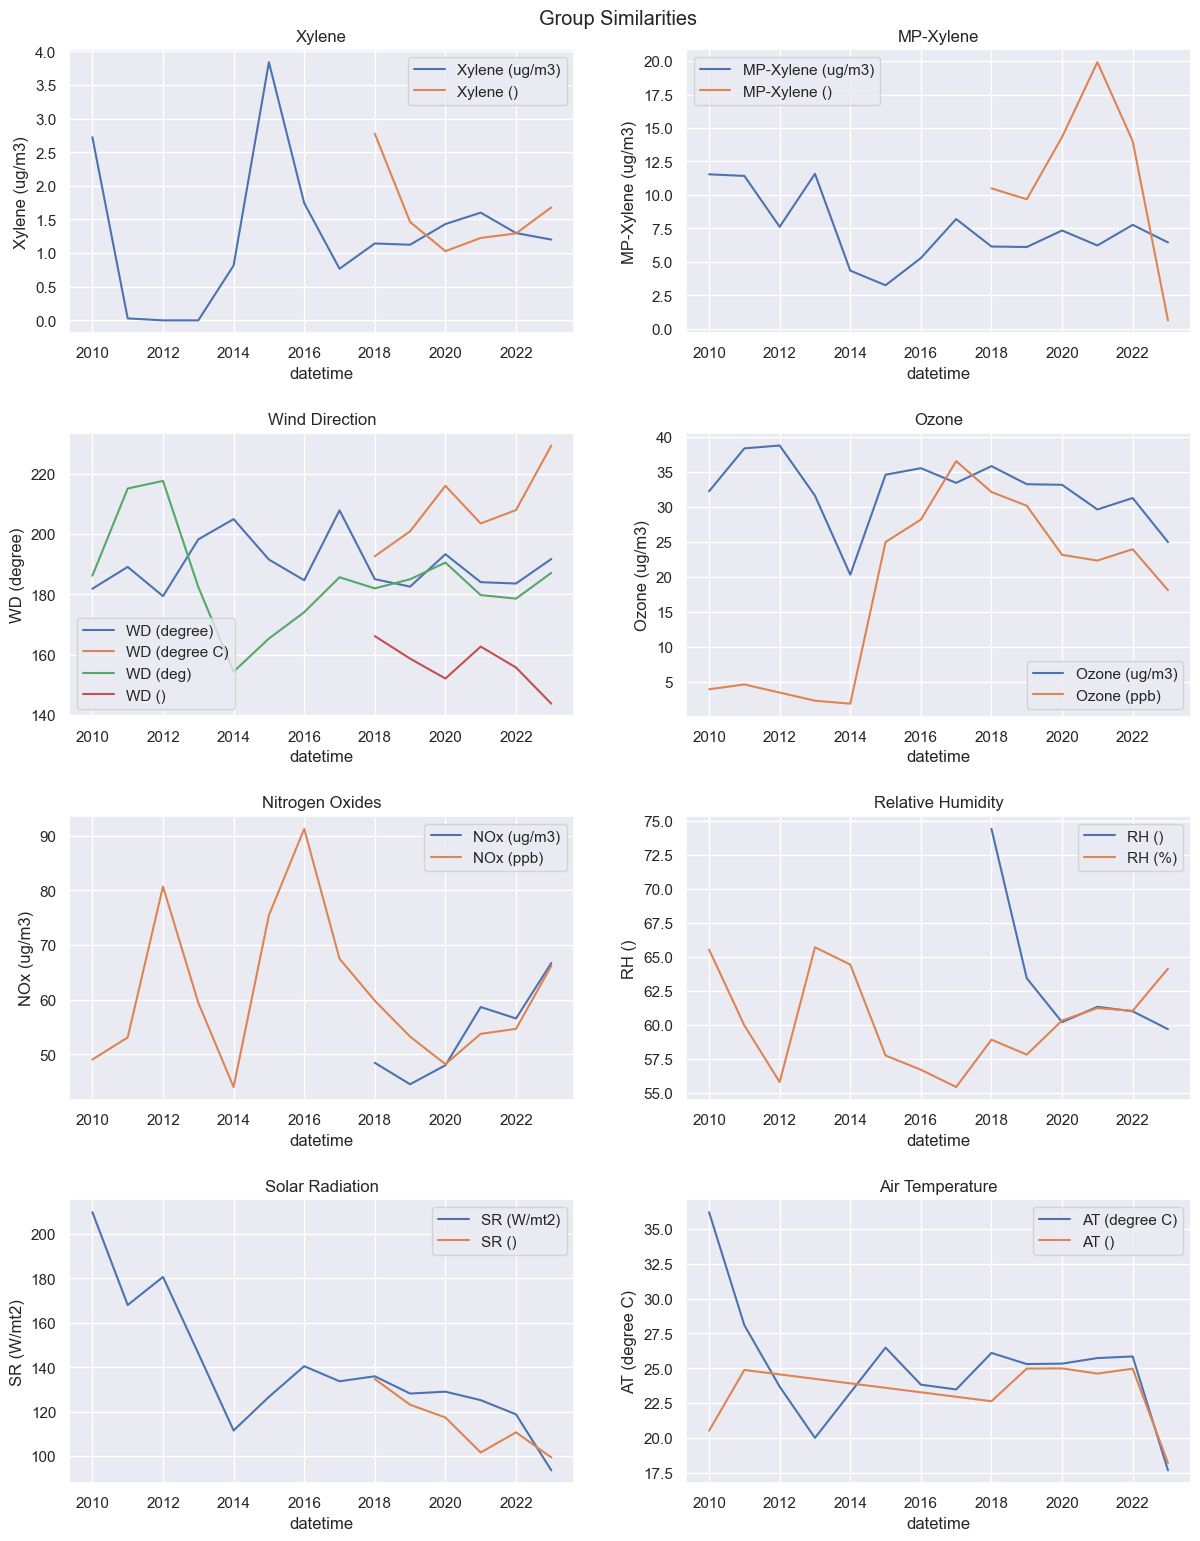

In [10]:
groups = {
    'Xylene':            ['Xylene (ug/m3)', 'Xylene ()'],
    "MP-Xylene":         ['MP-Xylene (ug/m3)', 'MP-Xylene ()'],
    'Wind Direction':    ["WD (degree)", "WD (degree C)", "WD (deg)", "WD ()"],
    'Ozone':             ['Ozone (ug/m3)', 'Ozone (ppb)'],
    'Nitrogen Oxides':   ['NOx (ug/m3)', 'NOx (ppb)'],
    'Relative Humidity': ['RH ()', 'RH (%)'],
    'Solar Radiation':   ['SR (W/mt2)', 'SR ()'],
    'Air Temperature':   ['AT (degree C)', 'AT ()']
}

plot_groups(df, groups, columns=2)

It seems like some of the features are capturing the same metric units as others. This is a good indication and we can double confirm by using the Pandas `describe`.

In [11]:
all_groups = [item for sublist in list(groups.values()) for item in sublist]
df[all_groups].describe().applymap(lambda x: f"{x:0.3f}")

,Xylene (ug/m3),Xylene (),MP-Xylene (ug/m3),MP-Xylene (),WD (degree),WD (degree C),WD (deg),WD (),Ozone (ug/m3),Ozone (ppb),NOx (ug/m3),NOx (ppb),RH (),RH (%),SR (W/mt2),SR (),AT (degree C),AT ()
count,242944.000,34578.000,264768.000,29205.000,813361.000,43888.000,655812.000,122463.000,1874697.000,47576.000,86086.000,1876466.000,39722.000,1611483.000,1555347.000,43267.000,1110834.000,83016.000
mean,1.337,1.319,7.040,13.824,186.417,205.871,184.905,157.480,32.370,25.864,52.076,56.894,62.812,59.893,130.106,116.041,25.136,24.178
std,5.762,3.348,13.603,19.986,94.905,88.418,80.286,91.992,34.778,19.535,59.768,70.730,20.497,22.548,180.273,172.197,8.561,8.426
min,0.000,0.000,0.010,0.010,0.020,1.200,0.030,1.300,0.010,0.050,0.100,0.000,0.820,0.010,0.000,2.720,0.100,1.880
25%,0.000,0.000,1.210,2.890,104.850,119.570,121.010,86.950,8.550,13.530,17.380,16.980,46.450,43.120,5.580,3.480,18.580,17.420
50%,0.000,0.400,2.940,7.040,187.380,230.435,185.310,147.830,19.600,20.480,31.050,31.680,63.820,61.330,29.500,11.350,26.400,25.380
75%,1.010,1.400,7.410,15.760,268.950,285.550,252.050,229.700,43.150,33.130,61.100,64.280,80.000,78.000,216.210,174.735,31.500,30.300
max,476.310,231.000,491.510,286.010,360.000,356.520,359.590,359.700,200.000,198.470,498.850,500.000,99.200,100.000,1995.000,836.420,58.900,56.270


I was able to merge the following features. The rest have too many missing values so we are going to drop them.

In [12]:
reduction_groups = {
    "Xylene (ug/m3)":    ["Xylene ()"],
    "MP-Xylene (ug/m3)": ["MP-Xylene ()"],
    "Benzene (ug/m3)":   ["Benzene ()"],
    "Toluene (ug/m3)":   ["Toluene ()"],
    "SO2 (ug/m3)":       ["SO2 ()"],
    "NOx (ug/m3)":       ["NOx (ppb)"],
    "Ozone (ug/m3)":     ["Ozone (ppb)"],
    "AT (degree C)":     ["AT ()"],
    "WD (degree)":       ["WD (degree C)", "WD (deg)", "WD ()"],
    "WS (m/s)":          ["WS ()"]
}

In [13]:
def reduce_columns(dataframe, columns):
    '''
    Merges column records into a single column.

    Parameters
    ----------
        dataframe (DataFrame):     The DataFrame to edit
        column (str):              The name of the column to merge records into
        cols_to_merge (list[str]): A list of column names to retrieve records
    '''
    
    for column, cols_to_merge in columns.items():
        # Check if the original column exist, otherwise create it
        if column not in dataframe.columns and any(name in dataframe.columns for name in cols_to_merge):
            dataframe[column] = np.nan

        for col_name in cols_to_merge:
            if col_name in dataframe.columns:
                dataframe[column] = dataframe[column].fillna(dataframe[col_name])
                dataframe = dataframe.drop(columns=[col_name])
            
    return dataframe

In [14]:
df = reduce_columns(df, reduction_groups)

### Missing Values

One important first thing to check now is how many missing values there are for these features.

In [15]:
df.isnull().sum().sort_values(ascending=False)

NMHC (ug/m3)           2796171
Eth-Benzene ()         2796171
SPM (ug/m3)            2796171
Gust (m/s)             2796171
Temp (ug/m3)           2796171
Gust (kl/h)            2796171
CO2 (mg/m3)            2796171
Power (W)              2796171
Variance (n)           2796171
Gust (km/hr)           2796171
CH4 ()                 2785343
HCHO (ug/m3)           2762343
Hg (ug/m3)             2761020
MH (m)                 2758723
BP ()                  2756663
RH ()                  2756449
SR ()                  2752904
CO (ng/m3)             2752432
CH4 (ug/m3)            2734776
THC (ug/m3)            2733520
CO (ug/m3)             2712197
O Xylene (ug/m3)       2611212
Eth-Benzene (ug/m3)    2568923
Xylene (ug/m3)         2518649
MP-Xylene (ug/m3)      2502198
VWS (m/s)              2370506
Temp (degree C)        2295873
RF (mm)                1899980
AT (degree C)          1602321
BP (mmHg)              1417134
NH3 (ug/m3)            1366814
Toluene (ug/m3)        1313863
Benzene 

Looks like we are dealing with a dataset which contains a lot of missing values. On a closer look we can observe that some of these feature columns are<br>
completely empty, so we can easily drop those columns.

In [16]:
df = df.dropna(how='all')
df = df.dropna(how='all', axis='columns')

I will create a function to see both the null value count as well as the percentages.

In [17]:
# Helper function that returs a DataFrame containing the number of null values and percentages for each column
def get_null_info(dataframe):
    null_vals = dataframe.isnull().sum()

    df_null_vals = pd.concat({'Null Count': null_vals,
                              'Percent Missing (%)': round(null_vals * 100 / len(dataframe), 2)}, axis=1)

    return df_null_vals.sort_values(by=['Null Count'], ascending=False)

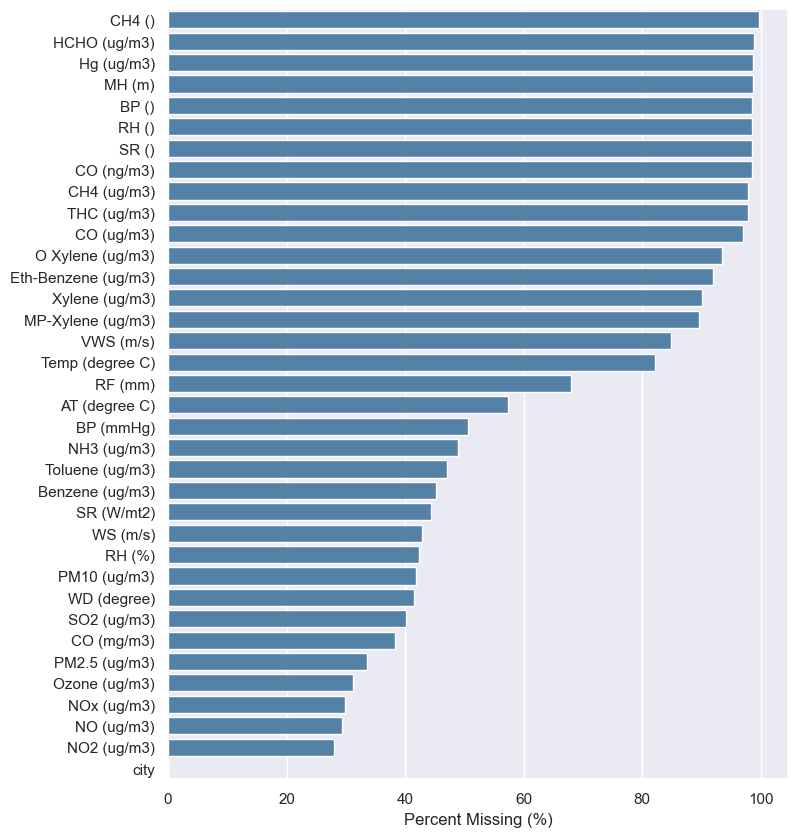

In [18]:
df_null_info = get_null_info(df)

plt.figure(figsize=(8, 10))
sns.barplot(data=df_null_info, x='Percent Missing (%)', y=df_null_info.index, orient='h', color='steelblue')
plt.show()

The barplot shows that the majority of features contain very little information.

#### Complete Null Count

So far we investigated only a single state. We may get a better feeling for the missing data if we investigate the complete dataset.

In [19]:
from IPython.display import clear_output

features = {}
total_records = 0

for i, state_name in enumerate(unique_states):
    clear_output(wait=False)
    print(f"Processing state of {state_name} ({i+1}/{len(unique_states)})")
    
    temp_df = combine_state_df(state_name)  # Get combined state dataframe
    temp_df = create_dt_index(temp_df)           # Create datetime index
    temp_df = temp_df.dropna(how='all')          # Drop empty rows

    comparisons = get_null_info(temp_df)
    
    total_records += df.shape[0]

    for feature in comparisons.index:
        if feature in features:
            features[feature] += comparisons.loc[[feature]]['Null Count'].values[0]
        else:
            features[feature] = comparisons.loc[[feature]]['Null Count'].values[0]

Processing state of West Bengal (31/31)
Combining a total of 14 files...



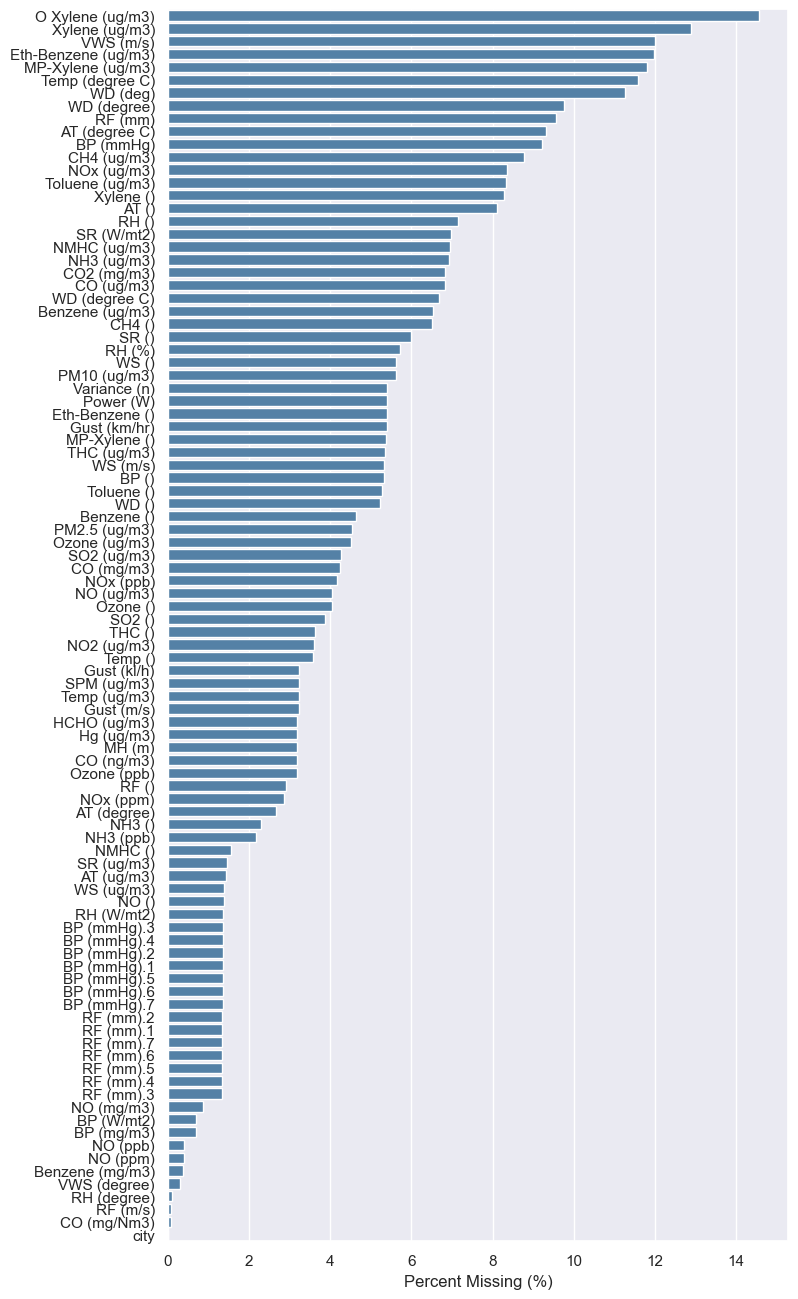

In [20]:
df_null_info = pd.DataFrame.from_dict(features, orient='index', columns=['Null Count'])
df_null_info['Percent Missing (%)'] = round(df_null_info['Null Count'] * 100 / total_records, 2)
df_null_info = df_null_info.sort_values(by=['Null Count'], ascending=False)

plt.figure(figsize=(8, 16))
sns.barplot(data=df_null_info, x='Percent Missing (%)', y=df_null_info.index, orient='h', color='steelblue')
plt.show()

From these barplots, we can deduce that the various states collected different kinds and amounts of metrics. Typically with datasets like these, people tend to keep<br>
the features that contain less than 25-30% missing values, unless they contain important information. I should also note here that these results show missing values<br>
for each individual state. Some states may not measure a feature, which case is not included in the above plot.

#### Drop Nulls by Threshold 

Back to our capital's dataframe, we can drop the columns which contain a certain thrueshold (i.e > 40%) of missing values.

In [21]:
# Threshold value indicating how much of the dataset needs to be not missing.
threshold = 0.6
df = df.dropna(thresh=df.shape[0]*threshold, axis=1)

In [22]:
get_null_info(df)

,Null Count,Percent Missing (%)
CO (mg/m3),1070972,38.30
PM2.5 (ug/m3),939895,33.61
Ozone (ug/m3),873898,31.25
NOx (ug/m3),833619,29.81
NO (ug/m3),821483,29.38
NO2 (ug/m3),783452,28.02
city,0,0.00


## Exploratory Data Analysis (EDA)

I am collecting the metrics (features) into several groups. This will enable better comparisons.

In [23]:
pollutants = {
    # A mixture of solid particles and liquid droplets found in the air.
    'Particulate Matter' : ['PM2.5 (ug/m3)', 'PM10 (ug/m3)'],

    # Nitrogen gases form when fuel is burned at high temperatures.
    'Nitrogen Compounds' : ['NOx (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'NH3 (ug/m3)'],

    # These are found in coal tar, crude petroleum, paint, vehicle exhausts and industrial emissions.
    'Hydrocarbons' : ['Benzene (ug/m3)', 'Eth-Benzene (ug/m3)', 'Xylene (ug/m3)', 'MP-Xylene (ug/m3)', 'O Xylene (ug/m3)', 'Toluene (ug/m3)'],

    # Released from the partial combustion of carbon-containing compounds.
    'Carbon Monoxide': ['CO (mg/m3)'],

    # Released naturally by volcanic activity and is produced as a by-product of copper extraction and the burning of sulfur-bearing fossil fuels.
    'Sulfur Dioxide': ['SO2 (ug/m3)'],

    # It is created mostly the combustion of fossil fuels.
    'Ozone Concentration' : ['Ozone (ug/m3)']
}

other_metrics = {
    # Affects Earth's average temperatures
    'Solar Radiation' : ['SR (W/mt2)'],

    'Temperatures' : ['Temp (degree C)', 'AT (degree C)'],

    'Relative Humidity' : ['RH (%)'],

    'Rainfall' : ['RF (mm)'],

    'Barometric Pressure' : ['BP (mmHg)'],

    'Wind Direction' : ['WD (degree)'],

    'Wind Speed' : ['WS (m/s)']
}


### Time Frequencies

Let's start by grouping our DataFrame by various frequencies.

In [24]:
slice_groups = {
    'Group by Day':   df.groupby(pd.Grouper(freq='1D')).mean(numeric_only=True),
    'Group by Month': df.groupby(pd.Grouper(freq='1M')).mean(numeric_only=True),
    'Group by Year':  df.groupby(pd.Grouper(freq='1Y')).mean(numeric_only=True)
}

In [25]:
def plot_metrics(features, slice_groups):    
    for feature in features:
        fig, ax = plt.subplots(1, 1, figsize=(12, 4))
        fig.suptitle(feature)
        
        labels = []
        for i, (group, group_df) in enumerate(slice_groups.items()):
            data_slice = group_df[group_df.columns.intersection(pollutants[feature])]
            
            # Keep only the NOx feature, as it combines both NO (Nitrogen Oxide) and NO2 (Nitrogen Dioxide)
            if feature == "Nitrogen Compounds":
                data_slice = data_slice.drop(['NO (ug/m3)', 'NO2 (ug/m3)'], axis=1)
                
            data_slice.plot(kind="line", ax=ax)
            
            for column in data_slice.columns:
                labels.append(f'{column} [{group}]')
            
        ax.legend(labels)    
        plt.plot()

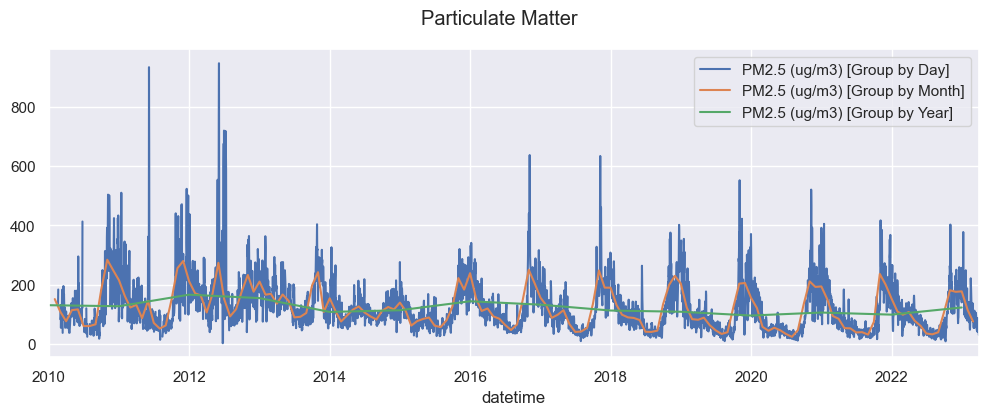

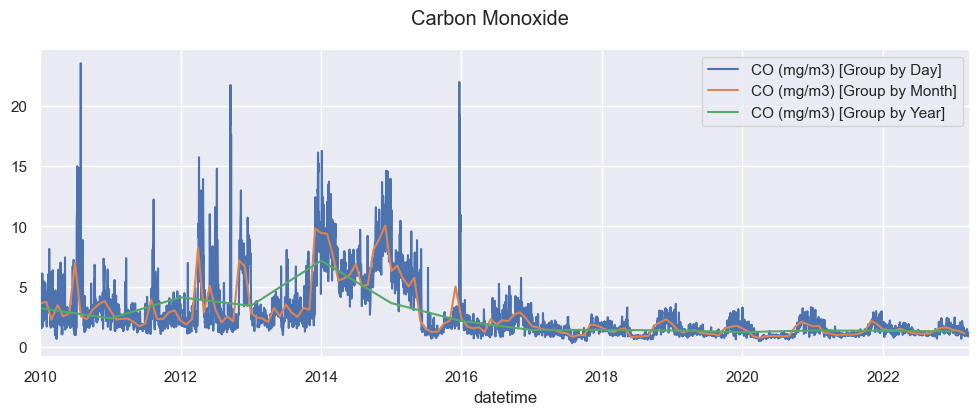

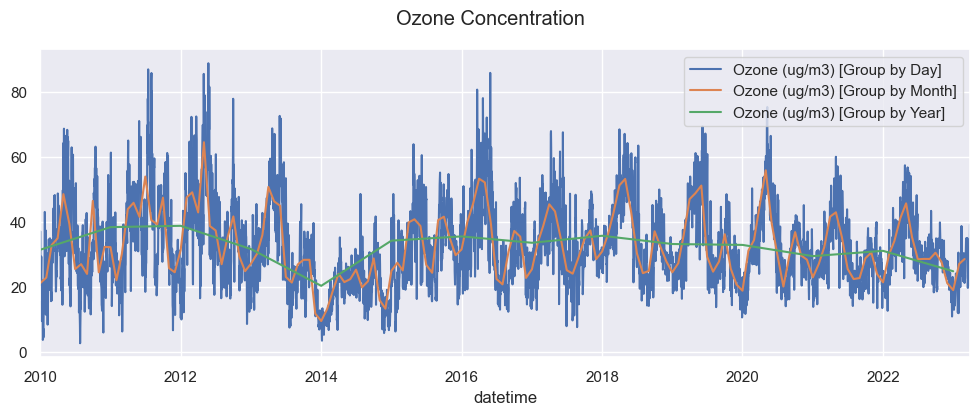

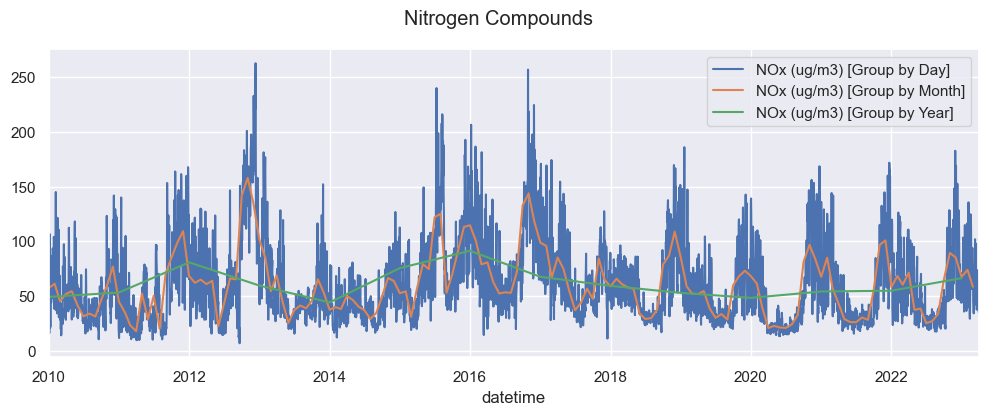

In [26]:
features_to_plot = ['Particulate Matter', 'Carbon Monoxide', 'Ozone Concentration', 'Nitrogen Compounds']
plot_metrics(features_to_plot, slice_groups)

### Year Slices

It looks like we are dealing with seasonal patterns on the metrics we selected. Let's dive a little bit deeper and try to understand<br>
what's happening per season on a yearly basis. For example let's consider a slice of the data, such as the year 2019-2020.

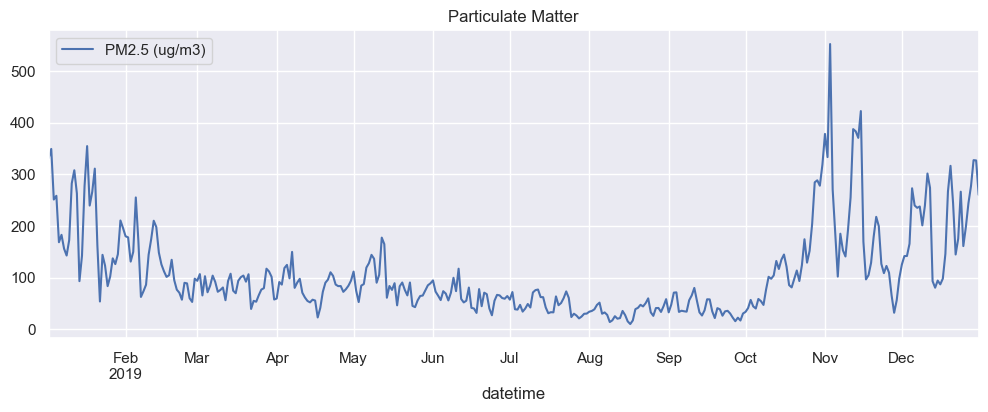

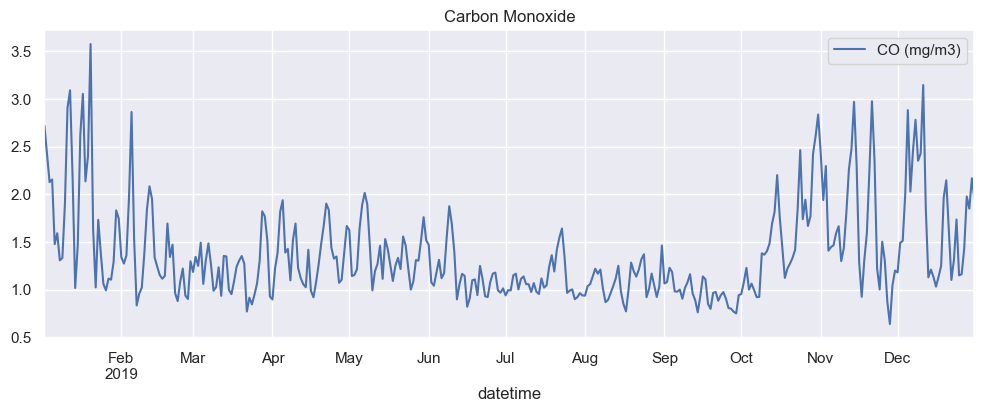

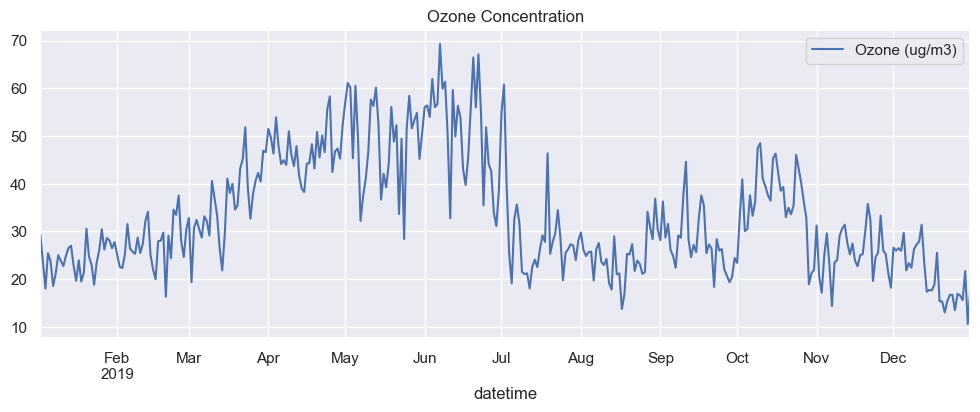

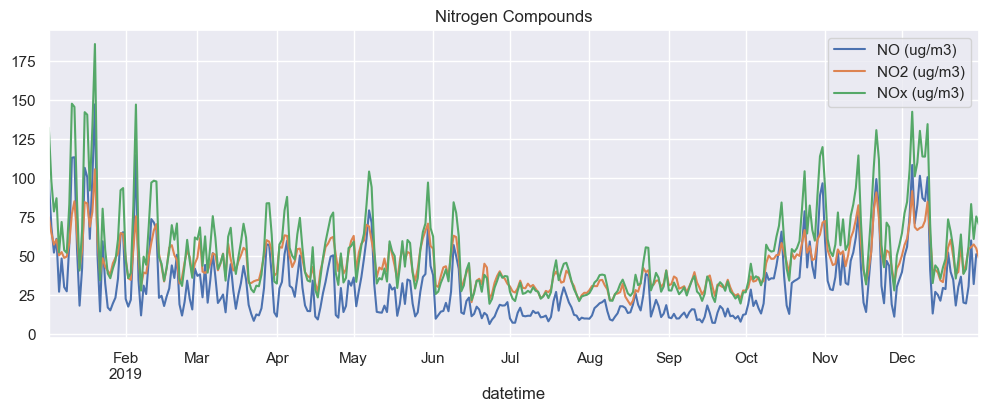

In [27]:
for feature in features_to_plot:
    data_slice = slice_groups['Group by Day'][slice_groups['Group by Day'].columns.intersection(pollutants[feature])]
    data_slice.query('datetime > 2019 and datetime < 2020').plot(title=feature, figsize=(12,4))

Here we can see that the values for the `Particulate Mater`, `Nitrogen Compounds` and `Carbon Monoxide`, start to increase around October<br>
and last until approxamatelly March. For the `Ozone Concentration` metric we see an opposite result, where the maximum values in a year<br>
are around mid May/June.

### PairPlot

We can see a better explanation on the relationships between the variables, as well as the distribution of each one through a pair plot.<br>

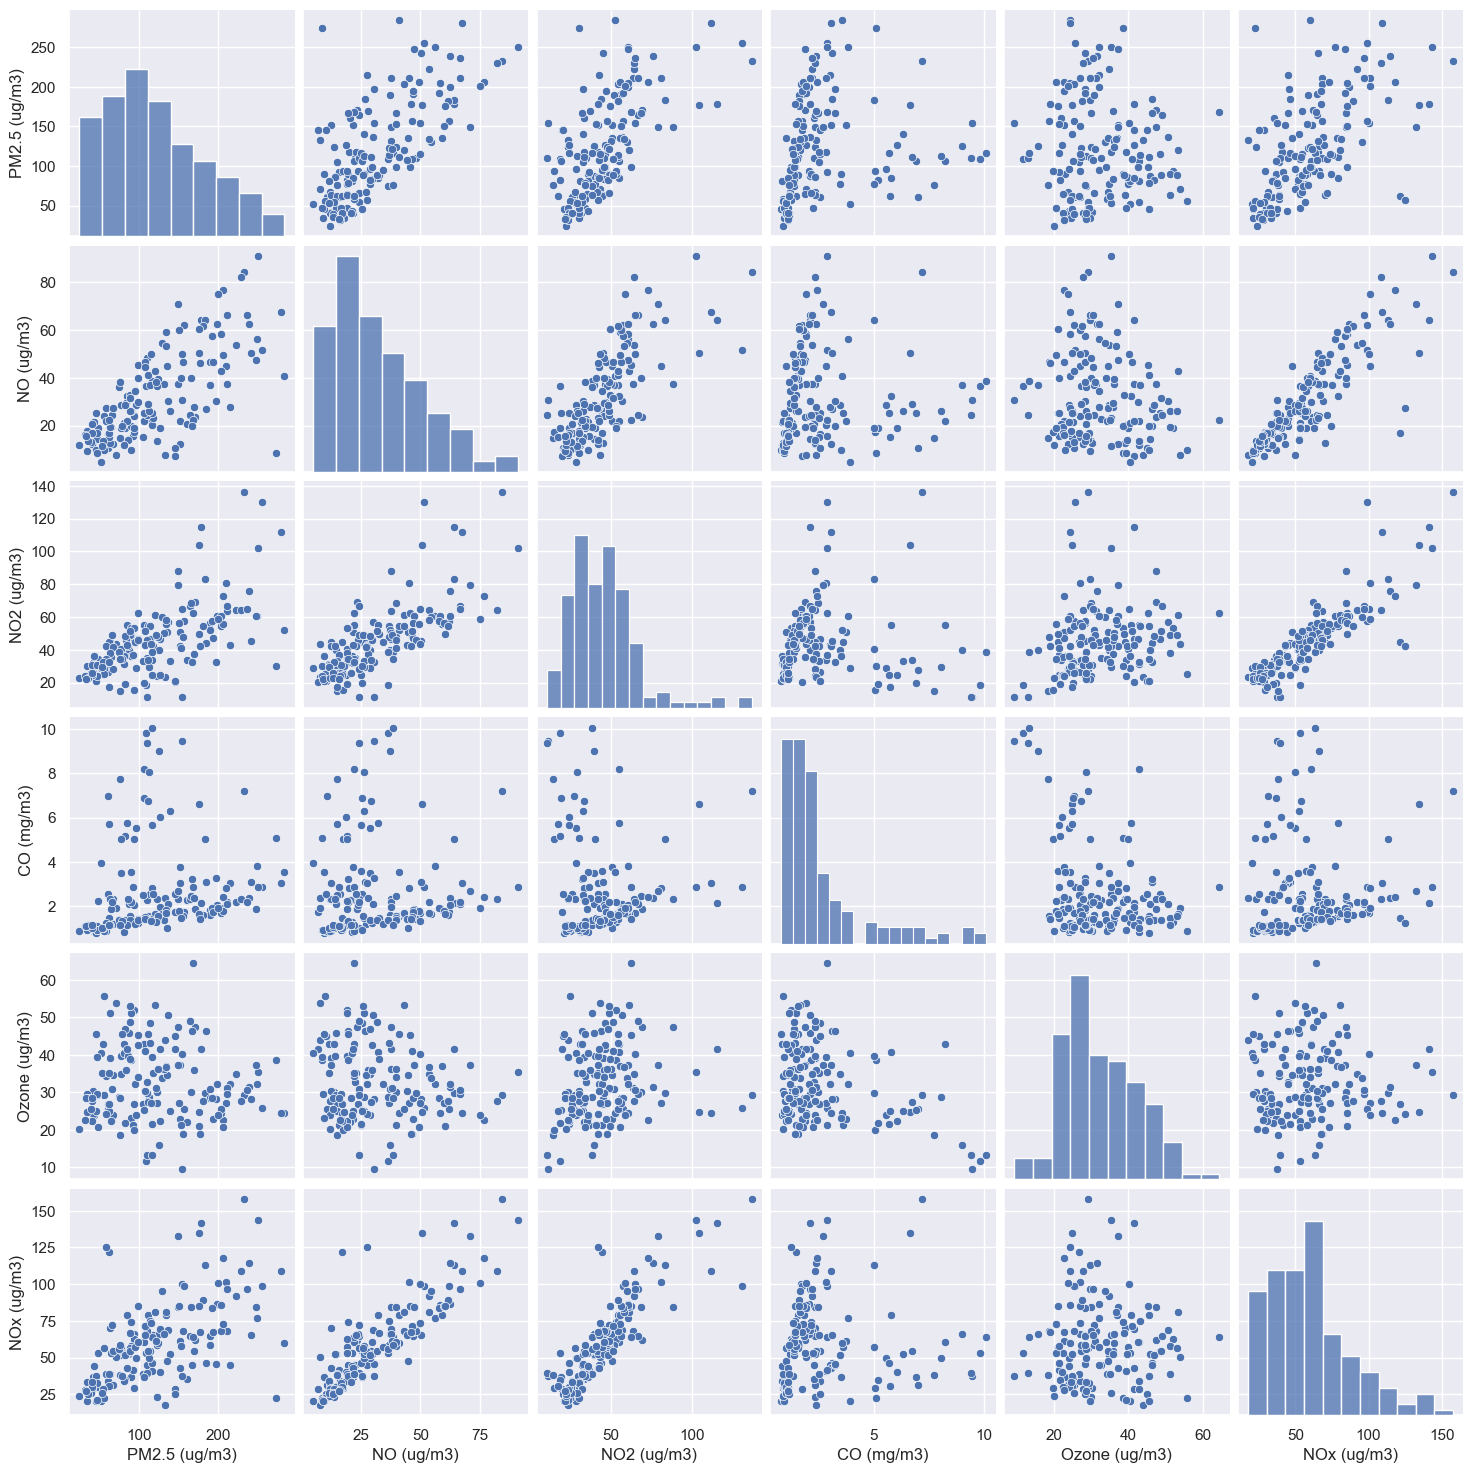

In [28]:
sns.pairplot(slice_groups['Group by Month'])

We can definatelly see here that the correlation between the Nitrogen Oxydes (NOx, NO, NO2) is quite linear.<br>
This is expected and we should probably just keep the generic feature, which is `NOx`.

### Correlation Matrix

Through a correlation matrix, we can easily visuallize the correlation degree between the variables.

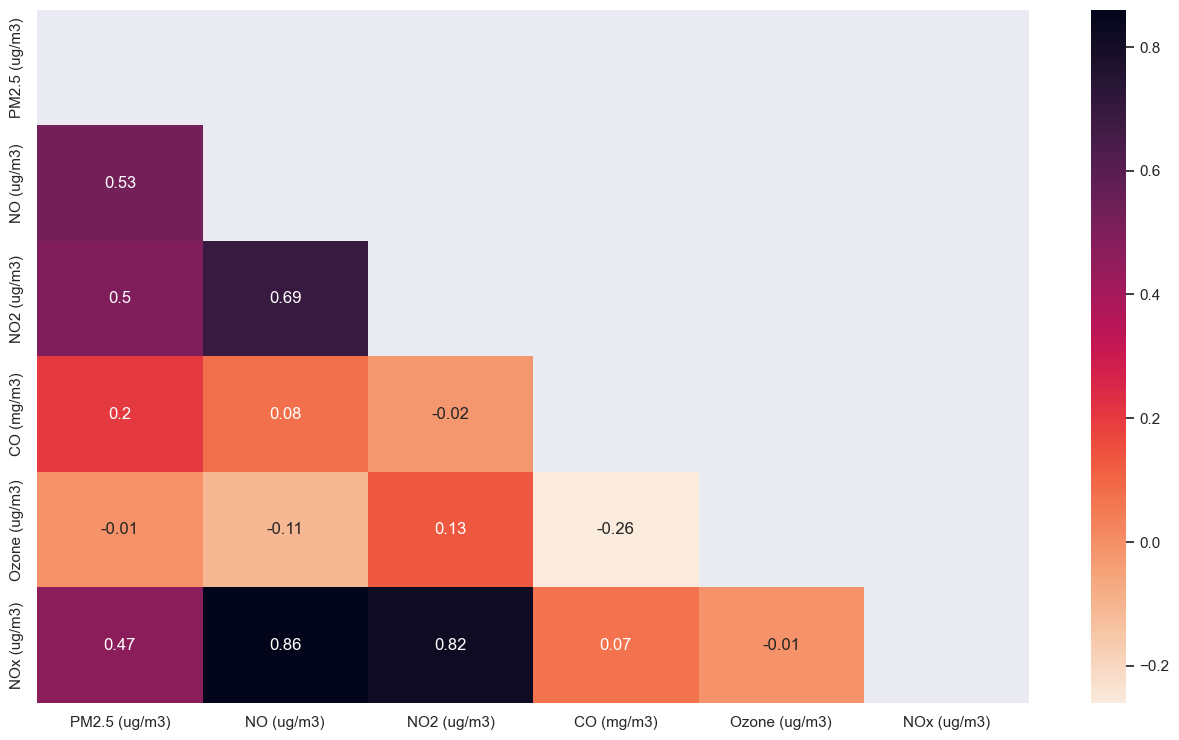

In [29]:
corr = slice_groups['Group by Day'].corr(numeric_only=True).round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(16,9))
sns.heatmap(data=corr, mask=mask, annot=True, cmap="rocket_r")
plt.show()

In [30]:
corr_target = abs(corr['PM2.5 (ug/m3)'])

relevant_features = corr_target[corr_target>0.4]

relevant_features.sort_values(ascending=False)

PM2.5 (ug/m3)    1.00
NO (ug/m3)       0.53
NO2 (ug/m3)      0.50
NOx (ug/m3)      0.47
Name: PM2.5 (ug/m3), dtype: float64

This plot shows us various high correlated features. For example:

- `NOx` is strongly correlated with the features `NO` and `NO2`.
- The particle accumulation feature `PM2.5` increases as the values of `NOx` increase.

Again, we see that it is fairly normal for the values of the *Nitrogen Compounds* to be highly correlated, as they represented in the same group.

## Feature Engineering

### Resampling

Secondly, this combined dataframe can contain data for the same timeframe as measurements ware made from various locations within the state. Here as I am<br>
interested in exploring the air quality in one state at a time, I will resample the same datetime measurements by taking the **mean** of the measurements.

In [31]:
df = df.resample('60min').mean(numeric_only=True)

### Feature Creation

Let's prepare our dataset by enhancing it with useful features and separating it into training/testing splits.

In [32]:
df['hour']      = df.index.hour
df['day']       = df.index.day
df['dayofweek'] = df.index.dayofweek
df['dayofyear'] = df.index.dayofyear
df['month']     = df.index.month
df['quarter']   = df.index.quarter
df['year']      = df.index.year

Now it is very easy to visualize the various metrics by the above features. One effective way is through boxplots. Let's for example check the air quality through the months.

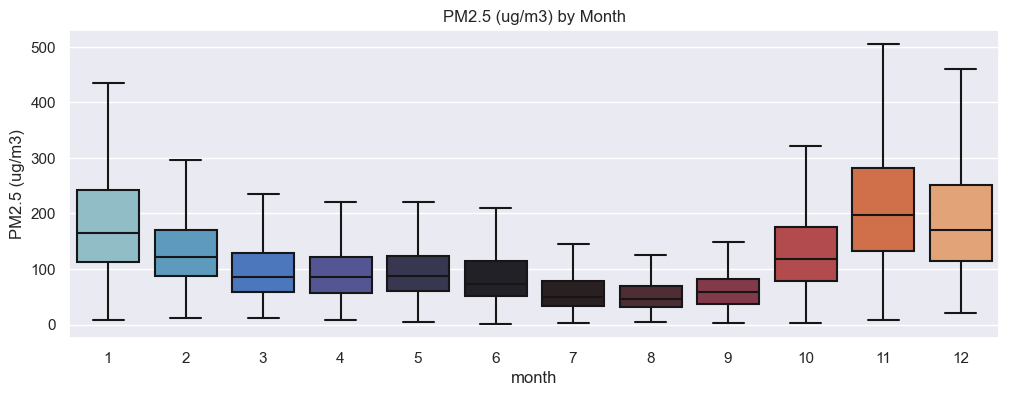

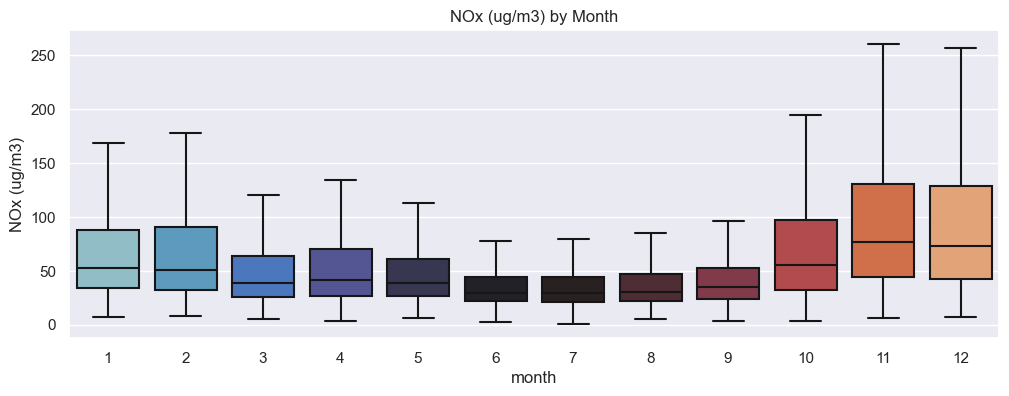

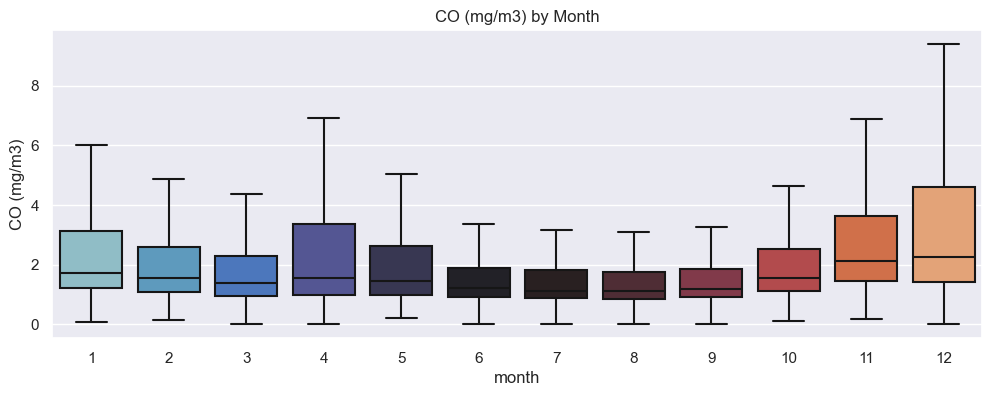

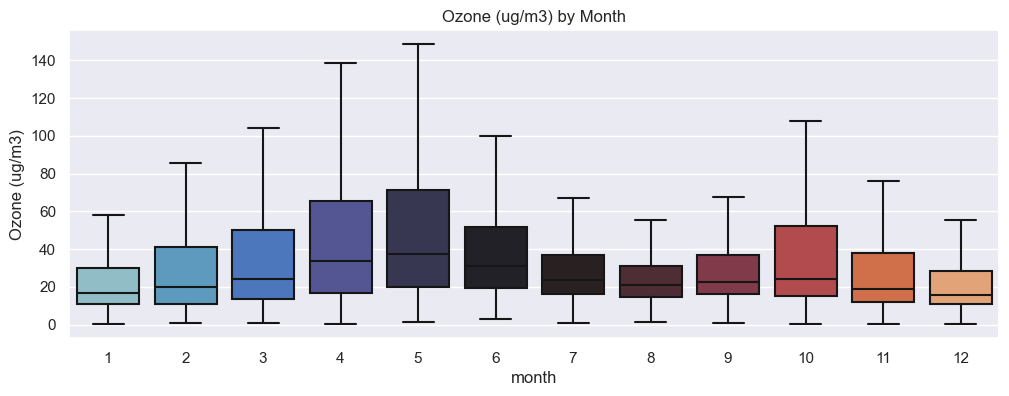

In [33]:
for metric in ['PM2.5 (ug/m3)', 'NOx (ug/m3)', 'CO (mg/m3)', 'Ozone (ug/m3)']:
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.boxplot(data=df, x='month', y=metric, palette="icefire", showfliers=False)
    ax.set_title(f'{metric} by Month')
    plt.show()

### Handling Missing Values

In [34]:
get_null_info(df)

,Null Count,Percent Missing (%)
PM2.5 (ug/m3),3877,3.34
CO (mg/m3),2090,1.80
NO2 (ug/m3),62,0.05
Ozone (ug/m3),62,0.05
NOx (ug/m3),54,0.05
NO (ug/m3),42,0.04
hour,0,0.00
day,0,0.00
dayofweek,0,0.00
dayofyear,0,0.00


In [35]:
df = df.interpolate(method='pad')
df = df.fillna(df.median())

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 116112 entries, 2010-01-01 00:00:00 to 2023-03-31 23:00:00
Freq: 60T
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   PM2.5 (ug/m3)  116112 non-null  float64
 1   NO (ug/m3)     116112 non-null  float64
 2   NO2 (ug/m3)    116112 non-null  float64
 3   CO (mg/m3)     116112 non-null  float64
 4   Ozone (ug/m3)  116112 non-null  float64
 5   NOx (ug/m3)    116112 non-null  float64
 6   hour           116112 non-null  int64  
 7   day            116112 non-null  int64  
 8   dayofweek      116112 non-null  int64  
 9   dayofyear      116112 non-null  int64  
 10  month          116112 non-null  int64  
 11  quarter        116112 non-null  int64  
 12  year           116112 non-null  int64  
dtypes: float64(6), int64(7)
memory usage: 12.4 MB


## Time Series Forecasting

Next I will try to do forecasting, based on the analysis.

To be continued...